In [35]:
# Import statements
import pandas as pd
import numpy as np
import torch
import math
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, precision_recall_fscore_support
import torch.nn.functional as F
from gensim.models import Word2Vec
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments, EvalPrediction
from tqdm import tqdm
from collections import Counter

In [88]:
# Load the dataset(s)

# Parse using pandas
data_sp = pd.read_csv('data/Spotify_F.csv')
data_ge = pd.read_csv('data/General_F.csv')

# Preparing the datasets

# Spotify sentences and labels first
sp_sents = data_sp['sent'].tolist() 
sp_labels = data_sp['label'].astype(int).tolist() 

# General sentences and labels second
ge_sents = data_ge['sent'].tolist() 
ge_labels = data_ge['label'].astype(int).tolist()   

# Split the dataset into training and test sets
# 80% (2400) of General becomes training data
# 20% (600) of General becomes testing data
# 100% (All) of Spotify becomes testing data
train_sents = ge_sents[0:2400]
train_labels = ge_labels[0:2400]
test_sents = ge_sents[2400:] + sp_sents
test_labels = ge_labels[2400:] + sp_labels

# Setup BERT encodings and tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
train_enc = tokenizer(train_sents, truncation=True, padding=True, max_length=12) 
test_enc = tokenizer(test_sents, truncation=True, padding=True, max_length=12)

# Setup LSTM tokens and tokenizer
def tokenize(sentences):                                  # Tokenize the sentences
    return [sentence.split() for sentence in sentences]   # Split via whitespace, each word is a list element

train_tokens = tokenize(train_sents) # Training tokens in a list
test_tokens = tokenize(test_sents)   # Test tokens in a list

In [7]:
# Word2Vec Model
word2vec = Word2Vec(sentences=train_tokens, vector_size=100, window=5, min_count=1, workers=4)

In [9]:
def compute_max_length(sentences): 
    # Compute max length of sentence for LSTM validation (error case)
    max_length = 0 
    for sentence in sentences: 
        length = len(sentence) 
        if length > max_length: 
            max_length = length 
    return max_length

In [11]:
# Create a PyTorch Dataset class
class TextDataset(Dataset):
    def __init__(self, sentences, labels, word2vec = word2vec, max_length = 10):
        self.sentences = sentences
        self.labels = labels
        self.word2vec = word2vec

        self.max_length = max_length

    def __len__(self):
        return len(self.sentences)

    def __getitem__(self, idx):
        sentence = self.sentences[idx]
        label = self.labels[idx]

        sentence_vec = [self.word2vec.wv[word] for word in sentence if word in self.word2vec.wv]
        if len(sentence_vec) == 0:
            sentence_vec = [np.zeros(self.word2vec.vector_size)]
        
        if len(sentence_vec) < self.max_length:
            padding = [np.zeros(self.word2vec.vector_size)] * (self.max_length - len(sentence_vec))
            sentence_vec.extend(padding)
        elif len(sentence_vec) > self.max_length:
            sentence_vec = sentence_vec[:self.max_length]

        sentence_vec = np.array(sentence_vec)

        return torch.tensor(sentence_vec, dtype=torch.float32), torch.tensor(label, dtype=torch.long)

In [13]:
# Create a PyTorch Dataset class for Bert specifically
class BertDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels']= torch.tensor(self.labels[idx], dtype = torch.long)
        return item

In [15]:
def remove_none_collate(batch):
    # Error case handling when the batch contains a None value
    batch = list(filter(lambda x: x is not None, batch))
    if not batch:
        return None
    return torch.utils.data.dataloader.default_collate(batch)

In [17]:
# Create DataLoader
# Each dataset below is a combination of the tokens or encodings from the dataset, plus the corresponding sentiment labels
# LABELS --
#  0 - Neutral
#  1 - Positive
# -1 - Negative

# Training sets creation for LSTM and BERT
train_dataset = TextDataset(train_tokens, train_labels, word2vec, compute_max_length(train_sents)) 
train_b_dataset = BertDataset(train_enc, train_labels)

# Testing sets creation for LSTM and BERT
test_dataset = TextDataset(test_tokens, test_labels, word2vec, compute_max_length(test_sents))      
test_b_dataset = BertDataset(test_enc, test_labels)

# The model will receive each dataset one at a time, in sample sizes of 16 items, and train_loader will be shuffled randomly
# Shuffled randomly to ensure it doesn't catch on to the pattern in the dataset (alternating grammatical / ungrammatical entries)
# Batch sizes are differed for each loader and used for separate models' training later
train_loader = DataLoader(train_dataset, batch_size = 16, collate_fn=remove_none_collate, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size = 1, collate_fn=remove_none_collate, shuffle = False)

In [19]:
# Define LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        _, (hidden, _) = self.lstm(x)
        out = self.fc(hidden[-1])
        return out

In [21]:
# Initialize models, loss, and optimizer
# Initialization done by creating instance objects of the classes above
input_size = 100
hidden_size = 128
output_size = 2  # Assuming binary classification

# Setting up LSTM model
lstm_model = LSTMModel(input_size, hidden_size, output_size) # Setting up LSTM Model

# Setting up BERT model
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels = 3)

criterion = nn.CrossEntropyLoss()
lstm_optimizer = optim.Adam(lstm_model.parameters(), lr=0.001)

# Get device hardware automatically
device = torch.device("mps" if torch.backends.mps.is_available() else ("cuda" if torch.cuda.is_available() else "cpu"))
lstm_model.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


LSTMModel(
  (lstm): LSTM(100, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)

In [23]:
# Training loop for LSTM model
def train_model(model, optimizer, train_loader, epochs):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for inputs, labels in tqdm(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader)}")

In [25]:
def compute_metrics(p: EvalPrediction):
    predictions, labels = p
    preds = predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)

    return {
        'accuracy':acc,
        'f1':f1,
        'precision':precision,
        'recall':recall
    }

In [27]:
# Train LSTM models with each epoch and batch size 
print("Training LSTM models...")
train_model(lstm_model, lstm_optimizer, train_loader, epochs = 5)

# Setup arguments and training BERT model
training_args = TrainingArguments( 
    output_dir = './results', 
    num_train_epochs = 3, 
    per_device_train_batch_size = 16, 
    per_device_eval_batch_size = 64, 
    warmup_steps = 500, 
    weight_decay = 0.01, 
    logging_dir = './logs', 
    logging_steps = 10, 
)

trainer = Trainer(
    model = model,
    args = training_args,
    train_dataset = train_b_dataset,
    eval_dataset = test_b_dataset,
    compute_metrics = compute_metrics
)

trainer.train()

Training LSTM models...


100%|█████████████████████████████████████████| 150/150 [00:02<00:00, 69.80it/s]


Epoch 1/5, Loss: 0.4938246925671895


100%|████████████████████████████████████████| 150/150 [00:01<00:00, 103.75it/s]


Epoch 2/5, Loss: 0.4917208743095398


100%|████████████████████████████████████████| 150/150 [00:01<00:00, 105.56it/s]


Epoch 3/5, Loss: 0.49144233028093975


100%|████████████████████████████████████████| 150/150 [00:01<00:00, 104.97it/s]


Epoch 4/5, Loss: 0.49107512772083284


100%|████████████████████████████████████████| 150/150 [00:01<00:00, 105.23it/s]


Epoch 5/5, Loss: 0.4907893309990565


Step,Training Loss
10,0.676000
20,0.741300
30,0.667300
40,0.666600
50,0.632100
60,0.656100
70,0.582400
80,0.520700
90,0.538900
100,0.508300


TrainOutput(global_step=450, training_loss=0.4076846543947856, metrics={'train_runtime': 101.7146, 'train_samples_per_second': 70.786, 'train_steps_per_second': 4.424, 'total_flos': 44400389241600.0, 'train_loss': 0.4076846543947856, 'epoch': 3.0})

In [29]:
# Evaluation function
def evaluate(model, data_loader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return all_labels, all_preds

In [37]:
def evaluate_lstm_model(model, dataloader, criterion, device):
    model.eval()
    all_preds = []
    all_labels = []
    total_loss = 0
    
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            
            preds = outputs.argmax(dim=1).cpu().numpy()
            labels = labels.cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels)
    
    avg_loss = total_loss / len(dataloader)
    acc = accuracy_score(all_labels, all_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='weighted')
    
    return {
        'loss': avg_loss,
        'accuracy': acc,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

In [74]:
# Getting the model performance values for BERT and LSTM

# Evaluate the LSTM model
print("Evaluating LSTM Model...")
lstm_res = evaluate_lstm_model(lstm_model, test_loader, criterion, device)

# Print the evaluation results
print(f"Loss: {lstm_res['loss'] * 100}")
print(f"Accuracy: {lstm_res['accuracy'] * 100}")
print(f"Precision: {lstm_res['precision'] * 100}")
print(f"Recall: {lstm_res['recall'] * 100}")
print(f"F1 Score: {lstm_res['f1'] * 100}")

print("Evaluating BERT Model...")
evaluation_results = trainer.evaluate()

# Extract and print each score
accuracy = evaluation_results.get('eval_accuracy', None)
precision = evaluation_results.get('eval_precision', None)
recall = evaluation_results.get('eval_recall', None)
f1_score = evaluation_results.get('eval_f1', None)
loss = evaluation_results.get('eval_loss', None)

print(f"Loss: {loss*100}")
print(f"Accuracy: {accuracy*100}")
print(f"Precision: {precision*100}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1_score*100}")

Evaluating LSTM Model...
Loss: 40.30519892865913
Accuracy: 6.809338521400778
Precision: 0.4636709109903253
Recall: 6.809338521400778
F1 Score: 0.8682216693953635
Evaluating BERT Model...


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Loss: 27.5674968957901
Accuracy: 37.604224569205115
Precision: 32.08224200992731
Recall: 0.37604224569205114
F1 Score: 32.67888159126974


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


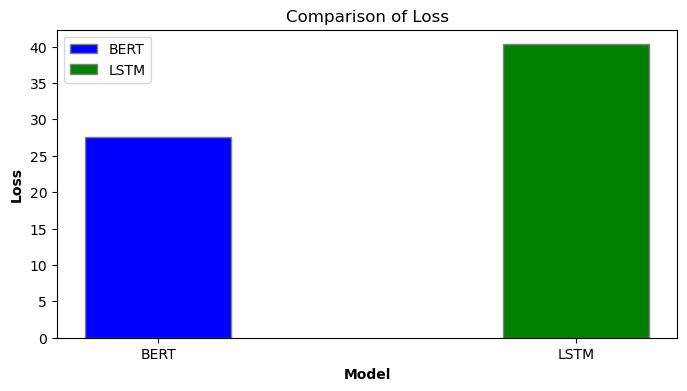

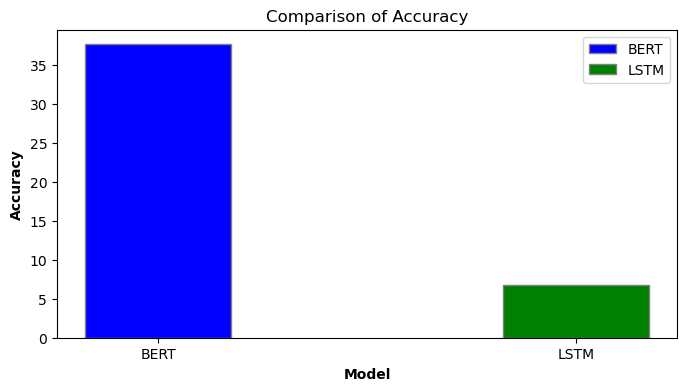

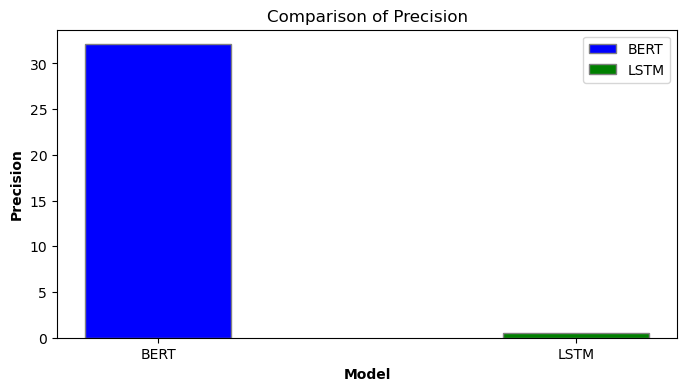

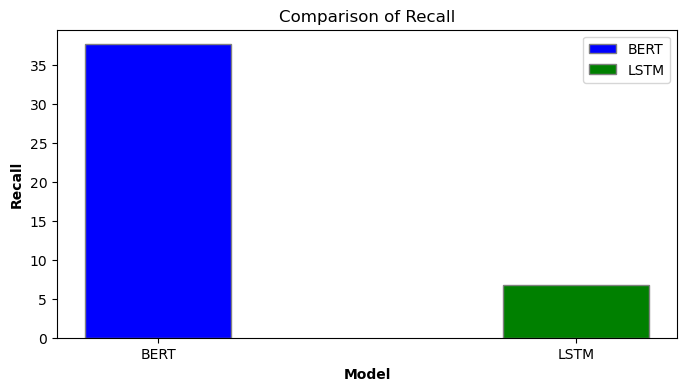

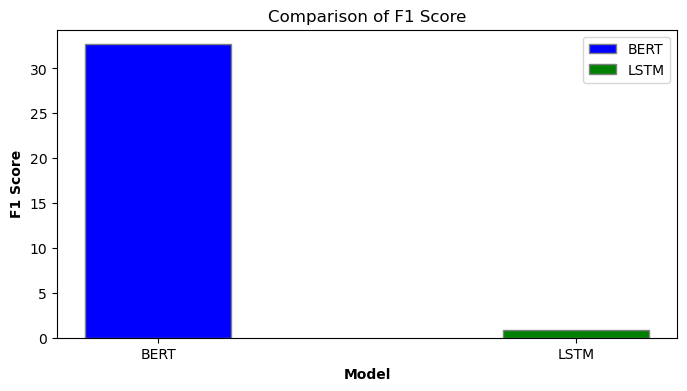

In [86]:
# Displaying Results

LSTM_results = {
    'Loss': lstm_res['loss']*100,
    'Accuracy': lstm_res['accuracy']*100,
    'Precision': lstm_res['precision']*100,
    'Recall': lstm_res['recall']*100,
    'F1 Score': lstm_res['f1']*100
}

BERT_results = {
    'Loss': loss*100,
    'Accuracy': accuracy*100,
    'Precision': precision*100,
    'Recall': recall*100,
    'F1 Score': f1_score*100
}

metrics = ['Loss', 'Accuracy', 'Precision', 'Recall', 'F1 Score']
metric_names = ['Loss', 'Accuracy', 'Precision', 'Recall', 'F1 Score']

# Extract values for each metric
BERT_values = [BERT_results[metric] for metric in metrics]
LSTM_values = [LSTM_results[metric] for metric in metrics]

# Creating individual plots for each metric
for i, metric in enumerate(metrics):
    plt.figure(figsize=(8, 4))
    bar_width = 0.35
    index = np.arange(2)
    plt.bar(index, [BERT_values[i], LSTM_values[i]], width=bar_width, color=['blue', 'green'], edgecolor='grey', label=['BERT', 'LSTM'])
    
    plt.xlabel('Model', fontweight='bold')
    plt.ylabel(metric_names[i], fontweight='bold')
    plt.xticks(index, ['BERT', 'LSTM'])
    plt.title(f'Comparison of {metric_names[i]}')
    plt.legend()
    plt.show()

